In [1]:
import numpy as np
import pydot
import graphviz
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.layers import Embedding, LSTM, Add
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
!pip install pydot

In [3]:
!pip install graphviz

# Get the X_train, y_train

In [4]:
import pickle
import numpy as np

## Load data for X1

### Import features file

In [5]:
features_file = '../output/extracted_features/encoded_images_6k.pkl'

In [6]:
file = open(features_file, 'rb')
features_dict = pickle.load(file)
file.close()

In [9]:
features_dict['2513260012_03d33305cf'][0].shape

(8, 8, 1280)

In [10]:
features_dict['2513260012_03d33305cf'].shape

(1, 8, 8, 1280)

## Create the X1_train

### Import captions data

In [11]:
captions_file = '../output/extracted_features/cap'

In [12]:
file = open(captions_file, 'rb')
x2_captions = pickle.load(file)
file.close()

In [13]:
cap_img_list = x2_captions[0] # first column with list of repeated image id's
len(cap_img_list)

353505

## Create X1_train

In [14]:
X1_train = []
for cap_img in cap_img_list[:12000]:
    img_feature_matrix = features_dict[cap_img][0]
    X1_train.append(img_feature_matrix)
X1_train = np.array(X1_train)
X1_train.shape

(12000, 8, 8, 1280)

## Create X2_train

In [15]:
X2_train = np.array(x2_captions[1]).astype(np.uint32)[:12000]
X2_train.shape

(12000, 36)

In [16]:
x2_captions[2][13]

array([3])

In [17]:
X2_train[14]

array([  2,   1,  34,   3,   1,  72, 129,   5, 121,  57,   1, 473,  12,
       624,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=uint32)

In [18]:
vocab_size = 7589


## Create y_train

In [19]:
y_train = np.array([el[0] if len(el)>0 else vocab_size+1 for el in x2_captions[2][:12000]])
y_train.shape

(12000,)

In [20]:
x2_captions=None
del x2_captions

## Create X1_train_new

#  CNN and LSTM sequence model

## CNN and LSTM Model layers

In [21]:
max_caption_length = 36
vocab_size =7589

In [22]:

inputs2  = Input(shape=(max_caption_length,),name="captions")
embed_layer = Embedding(vocab_size, 256, mask_zero=True)(inputs2)

# inputs1 = Input(shape=(256,256,3),name="images")

# CNN_model = EfficientNetB0(
#     include_top=False, # Whether to include the fully-connected layer at the top of the network
#     weights='imagenet', # pre-trained weights on ImageNet
#     input_tensor=None,
#     input_shape= (256,256,3), # It should have exactly 3 inputs channels
#     pooling=None # Optional pooling mode for feature extraction when include_top is False
# )
#CNN_model.trainable  = False

#CNN_model_output = CNN_model(inputs1)

input_encoded = Input(shape=(8,8,1280),name="images_encoded")

pooling = GlobalAveragePooling2D()(input_encoded)

cnn_dense = Dense(256, activation='relu')(pooling)


combine = Add()([embed_layer,cnn_dense])


2022-06-09 16:22:09.197443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 16:22:09.271570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 16:22:09.272225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 16:22:09.274560: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [23]:

lstm_layer = LSTM(256)(combine)
decoder = Dense(1000, activation='relu')(lstm_layer)
outputs = Dense(vocab_size, activation='softmax')(decoder)

##### Model summary Model summary

In [24]:

model = Model(inputs=[input_encoded, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy' , optimizer='adam',
             metrics = 'accuracy')

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 images_encoded (InputLayer)    [(None, 8, 8, 1280)  0           []                               
                                ]                                                                 
                                                                                                  
 captions (InputLayer)          [(None, 36)]         0           []                               
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['images_encoded[0][0]']         
 alAveragePooling2D)                                                                              
                                                                                              

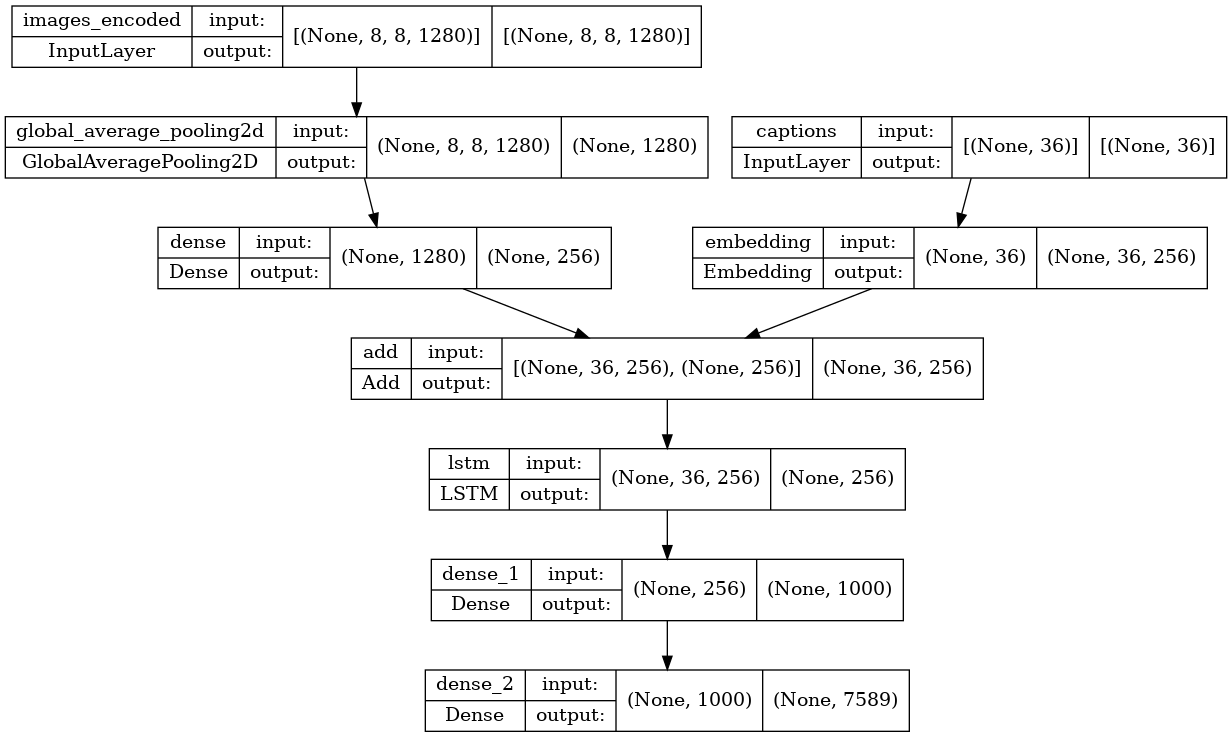

In [26]:
plot_model(model,show_shapes=True)

# Fit and train model 

In [27]:
import tensorflow as tf

In [28]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=7589)

In [29]:
y_train.shape

(12000, 7589)

In [30]:
# The fit
model.fit(
x=(X1_train,X2_train),
    y=y_train,
    batch_size=32,
    epochs=10, 
    verbose=1
)

2022-06-09 16:22:18.338743: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3932160000 exceeds 10% of free system memory.
2022-06-09 16:22:20.828941: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3932160000 exceeds 10% of free system memory.


Epoch 1/10


2022-06-09 16:22:29.056657: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


375/375 [==============================] - 13s 13ms/step - loss: 5.2562 - accuracy: 0.1657
Epoch 2/10
375/375 [==============================] - 5s 13ms/step - loss: 4.2744 - accuracy: 0.2447
Epoch 3/10
375/375 [==============================] - 5s 13ms/step - loss: 3.7208 - accuracy: 0.2871
Epoch 4/10
375/375 [==============================] - 5s 13ms/step - loss: 3.2892 - accuracy: 0.3304
Epoch 5/10
375/375 [==============================] - 5s 13ms/step - loss: 2.9126 - accuracy: 0.3683
Epoch 6/10
375/375 [==============================] - 5s 13ms/step - loss: 2.5478 - accuracy: 0.4155
Epoch 7/10
375/375 [==============================] - 5s 14ms/step - loss: 2.2058 - accuracy: 0.4533
Epoch 8/10
375/375 [==============================] - 5s 13ms/step - loss: 1.8925 - accuracy: 0.4935
Epoch 9/10
375/375 [==============================] - 5s 13ms/step - loss: 1.6213 - accuracy: 0.5414
Epoch 10/10
375/375 [==============================] - 5s 13ms/step - loss: 1.3893 - accuracy: 0.5781

In [72]:
import joblib

In [74]:
joblib.dump(model, '../output/model01_jlib')

INFO:tensorflow:Assets written to: ram://4fb44876-4321-4ef2-9f3c-c8d0e3a6ed4d/assets


INFO:tensorflow:Assets written to: ram://4fb44876-4321-4ef2-9f3c-c8d0e3a6ed4d/assets


['../output/model01_jlib']

# Predict the results

In [238]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [239]:
def CNN_output(file_id):
    
    CNN_model = EfficientNetB0(
    include_top=False, # Whether to include the fully-connected layer at the top of the network
    weights='imagenet', # pre-trained weights on ImageNet
    input_tensor=None,
    input_shape= (256,256,3), # It should have exactly 3 inputs channels
    pooling=None # Optional pooling mode for feature extraction when include_top is False
    )
    test_img_path = f"../raw_data/pics/Flicker8k_Dataset/{file_id}"
    
    test_img= image.load_img(test_img_path, target_size=(256,256,3))
    x_test = image.img_to_array(test_img)
    x_test = np.expand_dims(x_test, axis=0)
    test = CNN_model.predict(x_test)
    return test

In [240]:
def predic_seq(test):   
    inputs_seq='startsequence'
    img_encoded=test
    inputs_seq = [2]
    for i in range(36):
        inputs_seq_model = pad_sequences([inputs_seq],padding='post',maxlen=36)
        y_pre = model.predict([img_encoded,inputs_seq_model])
        next_word = y_pre.argmax()
        if next_word == 13:
            break
        inputs_seq.append(next_word)
    return inputs_seq

In [241]:
inputs_seq

[2, 1, 26, 18, 3, 1, 24, 31, 7, 1, 397, 31, 5, 43, 9, 1, 189]

In [242]:
def output_sentence(inputs_seq):
    file ='../output/extracted_features/word_index'
    # test_img_path = "../raw_data/pics/Flicker8k_Dataset/2458269558_277012780d.jpg"
    # test_img= image.load_img(test_img_path, target_size=(256,256,3))
    sentence  = []
    with open(file,'rb') as dictionary:
        b = pickle.load(dictionary)
    for number in inputs_seq:     
        sentence.append(list(b.keys())[list(b.values()).index(number)])
        final_sentence  = ' '.join(word for word in sentence[1:])
    return final_sentence
    # return test_img

In [243]:
output_sentence(inputs_seq)

'a little girl in a red shirt and a skirt shirt is sitting on a park'

In [250]:
def test_pre(number_image):
    img_list_file = '../raw_data/text/Flickr_8k.testImages.txt'
    img_list = np.loadtxt(img_list_file, dtype=str)
    img_folder_path = '../raw_data/pics/Flicker8k_Dataset/'
    images = number_image
    rand_img_index = np.random.randint(1001, size=images)
    rand_images = [img_list[i] for i in rand_img_index]
    # fig = plt.figure(figsize=(30,20));
    with open('../raw_data/text/Flickr8k.token.txt') as token_file:
        lines = token_file.readlines()
    image_tags = []
    captions = []
    for line in range(0,len(lines)):
        image_tags.append(lines[line].split('#')[0])
        captions.append(((lines[line].split('#')[1]).split('\t')[1]).split(' .')[0])
    for i in range(0,images):
        fig = plt.figure(figsize=(50,30));
        cnn_out = CNN_output(rand_images[i])
        seq_out = predic_seq(cnn_out)
        sent_out = output_sentence(seq_out)
        plt.subplot(images,1,i+1);
        img = image.load_img(img_folder_path+rand_images[i])
        image_out =plt.imshow(img);
        final_out =plt.title(f"Actual: {captions[image_tags.index(rand_images[i])]} \n Prediction: {sent_out}");
    # plt.title(sent_out)
    # return final_out, image_out

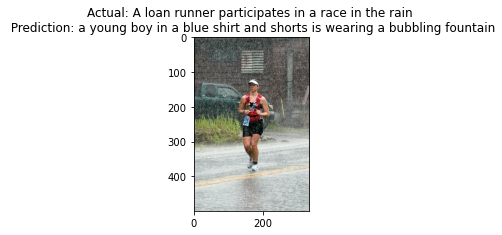

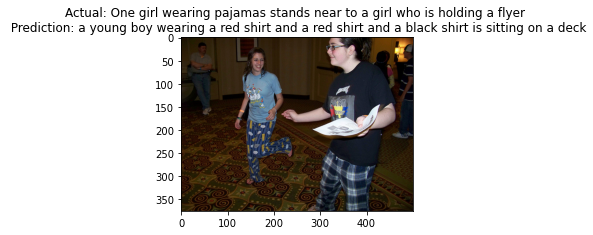

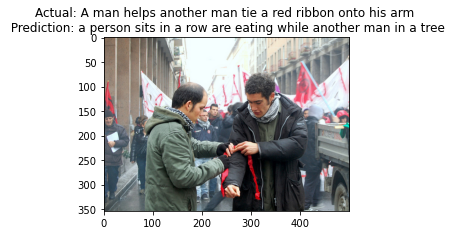

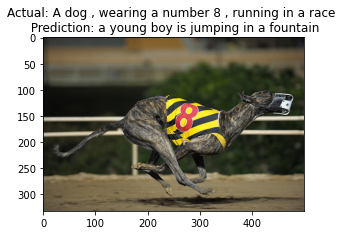

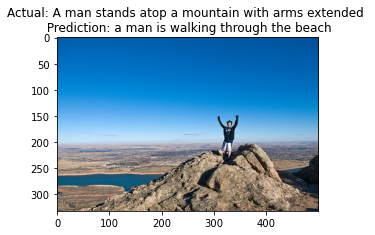

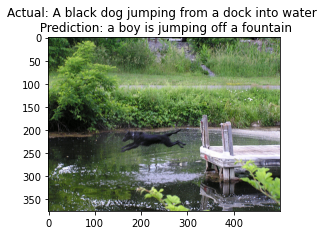

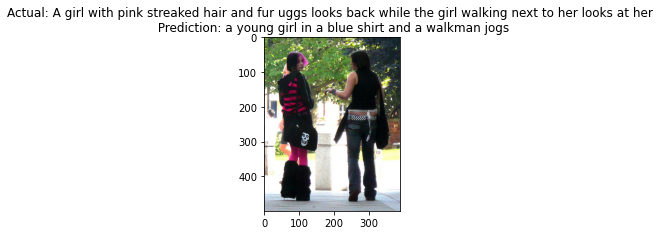

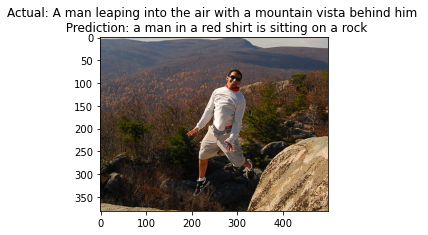

In [251]:
test_pre(8)